In [1]:
import sys
sys.path.append("/Users/ayushman/Desktop/retinanet_pet_detector/")

In [2]:
from omegaconf import OmegaConf
import logging
from references.utils import load_obj, get_label_dict
import argparse
from pytorch_retinanet.retinanet.models import Retinanet
from references.display_preds import Visualizer
from references.lightning import DetectionModel

In [3]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [4]:
image_dir = "/Users/ayushman/Desktop/Datasets/oxford-iiit-pet/images/"
annots = "/Users/ayushman/Desktop/Datasets/oxford-iiit-pet/annotations/xmls/"
labels = "/Users/ayushman/Desktop/retinanet_pet_detector/data/labels.names"
config_path = "/Users/ayushman/Desktop/retinanet_pet_detector/main.yaml"

In [5]:
# creat a dataframe from the xml files
!python ../references/data_utils.py \
    --action create \
    --img_dir="/Users/ayushman/Desktop/Datasets/oxford-iiit-pet/images/" \
    --annot_dir="/Users/ayushman/Desktop/Datasets/oxford-iiit-pet/annotations/xmls/" \
    --labels="/Users/ayushman/Desktop/retinanet_pet_detector/data/labels.names" \

INFO: Converting xml files to a csv file
INFO: Image Directory: /Users/ayushman/Desktop/Datasets/oxford-iiit-pet/images/
INFO: Annotation Directory: /Users/ayushman/Desktop/Datasets/oxford-iiit-pet/annotations/xmls/
INFO: Path to labels: /Users/ayushman/Desktop/retinanet_pet_detector/data/labels.names
INFO: Number of unique classes found: 37
INFO: csv file saved to current directory as `data-full.csv`


In [6]:
# create splits in the csv file
!python ../references/data_utils.py \
    --action split \
    --csv="data-full.csv" \
    --valid_size=0.2 \
    --test_size=0.5 \

INFO: path to the given csv file : data-full.csv
INFO: Creating train, validation and test splits
INFO: Number of training examples=2948
INFO: Number of validation examples=1843
INFO: Number of test examples=1843
INFO: Files saved to current directory


In [7]:
import pandas as pd
tmp = pd.read_csv("train.csv")
tmp.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/Users/ayushman/Desktop/Datasets/oxford-iiit-p...,500,500,128,22,240,222,german_shorthaired,14
1,/Users/ayushman/Desktop/Datasets/oxford-iiit-p...,333,500,97,35,304,199,english_setter,13
2,/Users/ayushman/Desktop/Datasets/oxford-iiit-p...,500,400,32,18,363,369,siamese,32
3,/Users/ayushman/Desktop/Datasets/oxford-iiit-p...,222,300,19,32,123,129,pomeranian,24
4,/Users/ayushman/Desktop/Datasets/oxford-iiit-p...,500,333,105,30,362,286,newfoundland,22


In [8]:
# instantiate the visualizer
labels = get_label_dict(labels)
vis = Visualizer(class_names=labels)

09/18/2020 20:07:13 - INFO - references.display_preds -   Visualizer Initialized


09/18/2020 20:07:13 - INFO - references.display_preds -   Found 1 bounding boxes on the given image


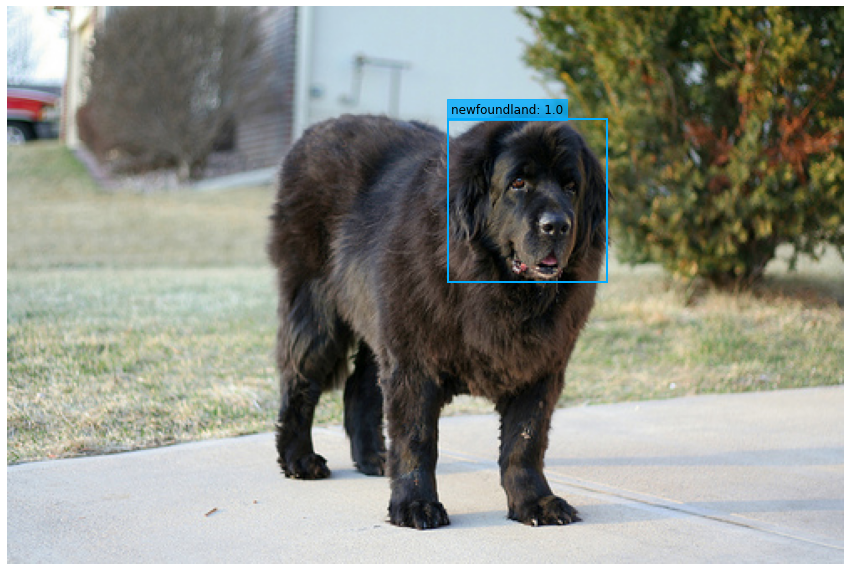

In [9]:
image_id = tmp.filename[10]
locs = tmp.loc[tmp.filename == image_id]
bboxes = locs[['xmin', 'ymin', 'xmax', 'ymax']].values
cls = locs['labels'].values

vis.draw_bboxes(image_id,bboxes,cls)

09/18/2020 20:07:14 - INFO - references.display_preds -   Found 1 bounding boxes on the given image


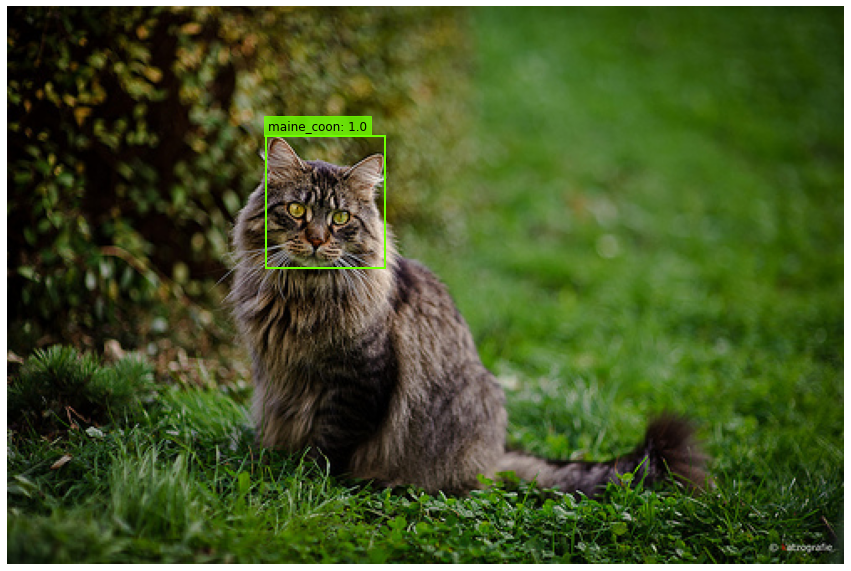

In [10]:
image_id = tmp.filename[100]
locs = tmp.loc[tmp.filename == image_id]
bboxes = locs[['xmin', 'ymin', 'xmax', 'ymax']].values
cls = locs['labels'].values

vis.draw_bboxes(image_id,bboxes,cls)

In [11]:
cfg = OmegaConf.load(config_path)
# check config file
print(OmegaConf.to_yaml(cfg))

model:
  backbone_kind: resnet34
  num_classes: 37
hparams:
  train_csv: data/train.csv
  valid_csv: data/valid.csv
  test_csv: data/test.csv
  train_batch_size: 4
  valid_batch_size: 32
  test_batch_size: 32
  iou_types: bbox
  optimizer:
    class_name: torch.optim.SGD
    params:
      lr: 0.002
      weight_decay: 0.001
      momentum: 0.9
  scheduler:
    class_name: torch.optim.lr_scheduler.MultiStepLR
    params:
      milestones:
      - 32
      - 55
      gamma: 0.1
    interval: epoch
    frequency: 1
  augmentation:
    train:
    - class_name: albumentations.HorizontalFlip
      params:
        p: 0.5
    - class_name: albumentations.ToGray
      params:
        p: 0.5
    - class_name: albumentations.CLAHE
      params:
        p: 0.5
    - class_name: albumentations.ToFloat
      params:
        always_apply: true
        max_value: 255.0
    - class_name: albumentations.pytorch.transforms.ToTensorV2
      params:
        always_apply: true
    valid:
    - class_name: a

In [12]:
# modify the paths of the config files
cfg.hparams.train_csv = "train.csv"
cfg.hparams.valid_csv = "valid.csv"
cfg.hparams.test_csv = "test.csv"

# cross-check
print(OmegaConf.to_yaml(cfg))

model:
  backbone_kind: resnet34
  num_classes: 37
hparams:
  train_csv: train.csv
  valid_csv: valid.csv
  test_csv: test.csv
  train_batch_size: 4
  valid_batch_size: 32
  test_batch_size: 32
  iou_types: bbox
  optimizer:
    class_name: torch.optim.SGD
    params:
      lr: 0.002
      weight_decay: 0.001
      momentum: 0.9
  scheduler:
    class_name: torch.optim.lr_scheduler.MultiStepLR
    params:
      milestones:
      - 32
      - 55
      gamma: 0.1
    interval: epoch
    frequency: 1
  augmentation:
    train:
    - class_name: albumentations.HorizontalFlip
      params:
        p: 0.5
    - class_name: albumentations.ToGray
      params:
        p: 0.5
    - class_name: albumentations.CLAHE
      params:
        p: 0.5
    - class_name: albumentations.ToFloat
      params:
        always_apply: true
        max_value: 255.0
    - class_name: albumentations.pytorch.transforms.ToTensorV2
      params:
        always_apply: true
    valid:
    - class_name: albumentations.T

In [13]:
torch_model = Retinanet(**cfg.model)

09/18/2020 20:07:17 - INFO - root -   Backbone : resnet34
09/18/2020 20:07:17 - INFO - root -   Score Threshold : 0.05
09/18/2020 20:07:17 - INFO - root -   NMS Threshold : 0.5
09/18/2020 20:07:17 - INFO - root -   Num Classes : 37


In [14]:
litModel = DetectionModel(torch_model, hparams=cfg.hparams)

In [15]:
# Check if dataloader is working
litModel.prepare_data()
dl = litModel.train_dataloader()

In [24]:
bs = next(iter(dl))
bs

((tensor([[[0.3608, 0.2745, 0.2039,  ..., 0.3961, 0.4667, 0.5922],
           [0.3725, 0.2863, 0.2157,  ..., 0.4118, 0.4980, 0.6275],
           [0.3765, 0.2902, 0.2196,  ..., 0.4235, 0.5294, 0.6627],
           ...,
           [0.6157, 0.6824, 0.7451,  ..., 0.8314, 0.8118, 0.7608],
           [0.6196, 0.6902, 0.7490,  ..., 0.7294, 0.7882, 0.7922],
           [0.6235, 0.6902, 0.7529,  ..., 0.8902, 0.7216, 0.6980]],
  
          [[0.3608, 0.2745, 0.2039,  ..., 0.3961, 0.4667, 0.5922],
           [0.3725, 0.2863, 0.2157,  ..., 0.4118, 0.4980, 0.6275],
           [0.3765, 0.2902, 0.2196,  ..., 0.4235, 0.5294, 0.6627],
           ...,
           [0.6157, 0.6824, 0.7451,  ..., 0.8314, 0.8118, 0.7608],
           [0.6196, 0.6902, 0.7490,  ..., 0.7294, 0.7882, 0.7922],
           [0.6235, 0.6902, 0.7529,  ..., 0.8902, 0.7216, 0.6980]],
  
          [[0.3608, 0.2745, 0.2039,  ..., 0.3961, 0.4667, 0.5922],
           [0.3725, 0.2863, 0.2157,  ..., 0.4118, 0.4980, 0.6275],
           [0.3765, 0.

In [16]:
# check transoformations
litModel.tfms

{'train': Compose([
   HorizontalFlip(always_apply=False, p=0.5),
   ToGray(always_apply=False, p=0.5),
   CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8)),
   ToFloat(always_apply=True, p=1.0, max_value=255.0),
   ToTensorV2(always_apply=True, p=1.0),
 ], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['class_labels'], 'min_area': 0.0, 'min_visibility': 0.0}, keypoint_params=None, additional_targets={}),
 'valid': Compose([
   ToFloat(always_apply=True, p=1.0, max_value=255.0),
   ToTensorV2(always_apply=True, p=1.0),
 ], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['class_labels'], 'min_area': 0.0, 'min_visibility': 0.0}, keypoint_params=None, additional_targets={}),
 'test': Compose([
   ToFloat(always_apply=True, p=1.0, max_value=255.0),
   ToTensorV2(always_apply=True, p=1.0),
 ], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['class_labels'], 'min_area': 0.0, 'min_visibility': 0.0}, keypoint_params=None, addit

In [26]:
# check optimizer and scheduler
_ =litModel.configure_optimizers()

In [27]:
# crosscheck optimizer and scheduler
litModel.optimizer, litModel.scheduler

(SGD (
 Parameter Group 0
     dampening: 0
     initial_lr: 0.002
     lr: 0.002
     momentum: 0.9
     nesterov: False
     weight_decay: 0.001
 ),
 <torch.optim.lr_scheduler.MultiStepLR at 0x7ffdc04f0450>)

In [25]:
# litModel.optimizer.defaults, litModel.optimizer.param_groups